In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from pprint import pprint

from sklearn.datasets import fetch_20newsgroups

import re
import nltk
from nltk.corpus import stopwords

import time
from sentence_transformers import SentenceTransformer

In [29]:
categories = [
 'comp.os.ms-windows.misc',
 'rec.sport.hockey',
 'soc.religion.christian',
]

dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, remove=('headers', 'footers', 'quotes'))
data = {'text': dataset.data, 'target': dataset.target}
df = pd.DataFrame(data)

In [30]:
def preprocess_text(text: str) -> str:
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    
    # remove stopwords
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
    text = " ".join(tokens)
    text = text.lower().strip()
    
    return text

In [31]:
# nltk.download('punkt')
# nltk.download('stopwords')
df['text_cleaned'] = df['text'].apply(lambda text: preprocess_text(text))
df = df[df['text_cleaned'] != '']


In [32]:
st = time.time()

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
df['encode_transforemers'] = df['text_cleaned'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))

X_transformers = np.vstack(df['encode_transforemers'])

truelabel = df['target'].values.tolist()

Elapsed time: 64.78 seconds


In [33]:
print(X_transformers)

[[-0.19556543 -0.05869391 -0.10201951 ... -0.07405631  0.01389422
   0.21891697]
 [-0.71055967 -0.32453373  0.05747779 ... -0.22413746  0.6148694
   0.2831625 ]
 [-0.25970042 -0.2751938   0.17308067 ...  0.13216859  0.14109923
   0.21804576]
 ...
 [-0.28117606  0.85472846 -0.5935314  ... -0.14927004 -0.30565965
  -0.16400482]
 [-0.54576725  0.59592503 -0.1194267  ... -0.00458279  0.10226101
  -0.09212881]
 [-0.8401029  -0.152213   -0.5517539  ...  0.27727464  0.1968017
   0.0507758 ]]


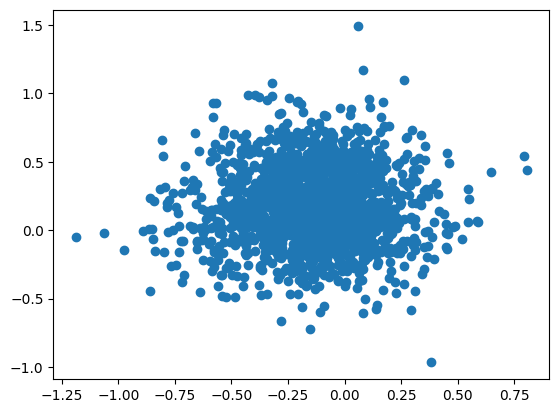

In [34]:
plt.scatter(X_transformers[:,0], X_transformers[:,1])
plt.show()

In [35]:
cl = {-1: 'k',
 0 : 'r',
 1 : 'g',
 2 : 'b',
 3 : 'c',
 4 : 'm',
 5 : 'y'}

In [36]:
from sklearn.cluster import DBSCAN 

db_default = DBSCAN().fit(X_transformers) 
db_labels = db_default.labels_

print("DBSCAN")
print(np.unique(db_default.labels_))
print(db_default.labels_)

DBSCAN
[-1]
[-1 -1 -1 ... -1 -1 -1]


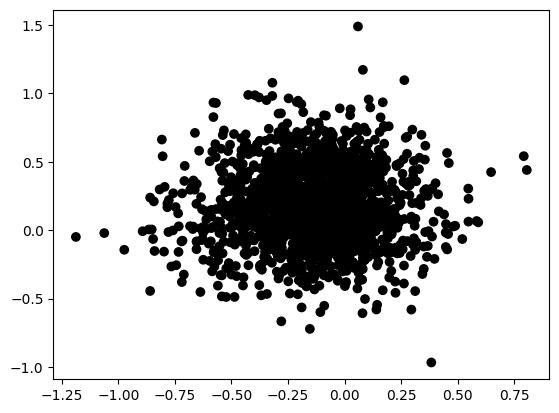

In [37]:
cvec = [cl[label] for label in db_labels]
plt.scatter(X_transformers[:,0], X_transformers[:,1], c = cvec) 
plt.show()

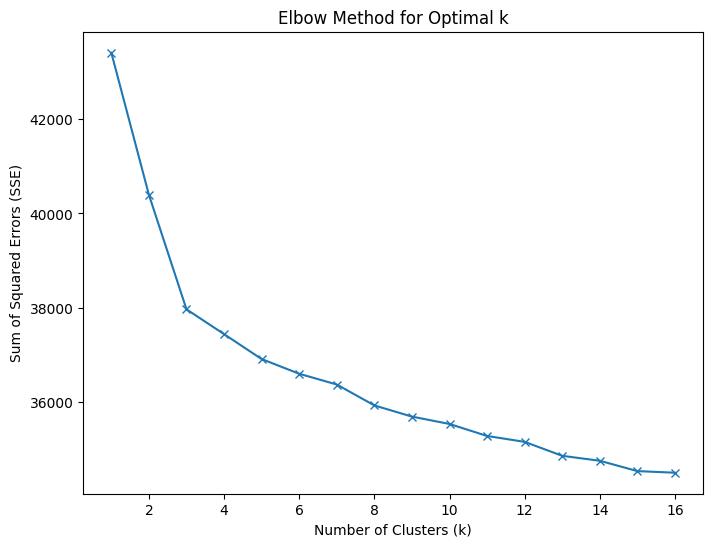

In [38]:
from sklearn.cluster import KMeans

sse = [] 
k_range = range(1,17)
for k in k_range:
    kmeans = KMeans(n_clusters=k,random_state=0,n_init="auto").fit(X_transformers)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(k_range,sse,marker='x')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

    

In [39]:
sse_diff = np.diff(sse)
sse_diff2 = np.diff(sse_diff)
optimal_k = np.argmin(sse_diff) + 2
print(optimal_k)

2


In [40]:

kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init="auto").fit(X_transformers)
kmeans_labels = kmeans.labels_

print("Kmeans")
print(kmeans.labels_)
print(np.unique(kmeans.labels_))

Kmeans
[0 0 0 ... 1 1 0]
[0 1]


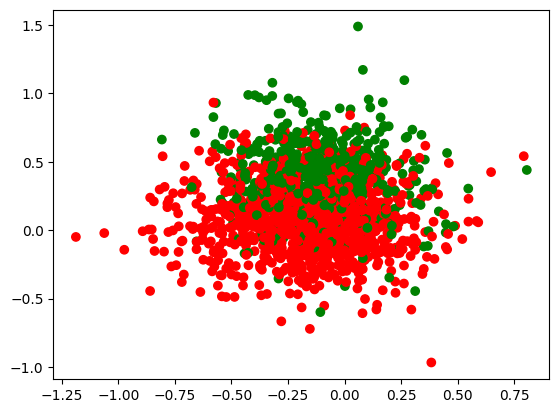

In [41]:
cvec = [cl[label] for label in kmeans_labels]
plt.scatter(X_transformers[:,0], X_transformers[:,1], c = cvec) 
plt.show()

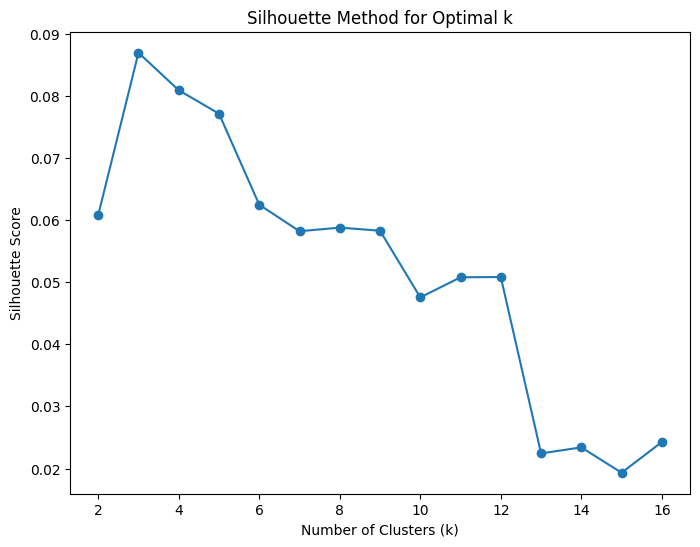

3


In [43]:
from sklearn.metrics import silhouette_score
silhouette_scores= [] 
k_range = range(2,17)
for k in k_range:
    kmeans = KMeans(n_clusters=k,random_state=0,n_init="auto").fit(X_transformers)
    labels = kmeans.labels_
    score = silhouette_score(X_transformers, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(optimal_k_silhouette)

In [44]:
kmeans = KMeans(n_clusters=optimal_k_silhouette, random_state=0, n_init="auto").fit(X_transformers)
kmeans_labels = kmeans.labels_

print("Kmeans")
print(kmeans.labels_)
print(np.unique(kmeans.labels_))

Kmeans
[0 0 2 ... 1 1 0]
[0 1 2]


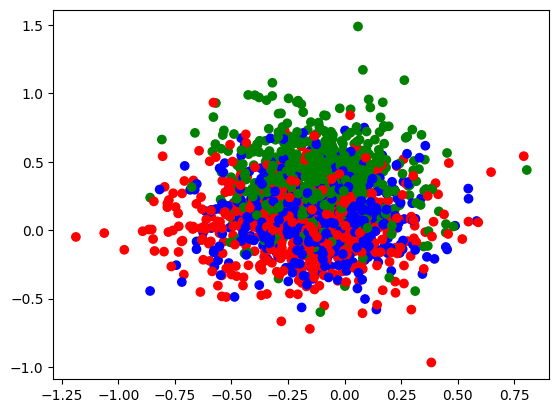

In [45]:
silhouette = [cl[label] for label in kmeans_labels]
plt.scatter(X_transformers[:,0], X_transformers[:,1], c = silhouette) 
plt.show()

In [42]:
from sklearn import metrics
print("DBSCAN", metrics.rand_score(truelabel, db_labels))
print("KMEANS", metrics.rand_score(truelabel, kmeans_labels))

DBSCAN 0.3330441614345039
KMEANS 0.7542646252979197


Extracted 200 texts from images.
Number of texts after preprocessing: 200


c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\subpr

DBSCAN
[-1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]


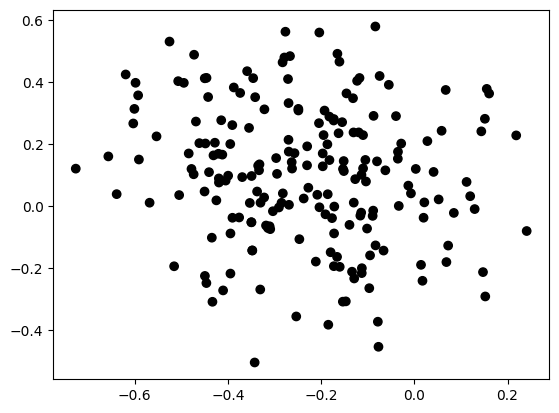

c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\site-packages\sklearn\cluster\_kmeans.py:14

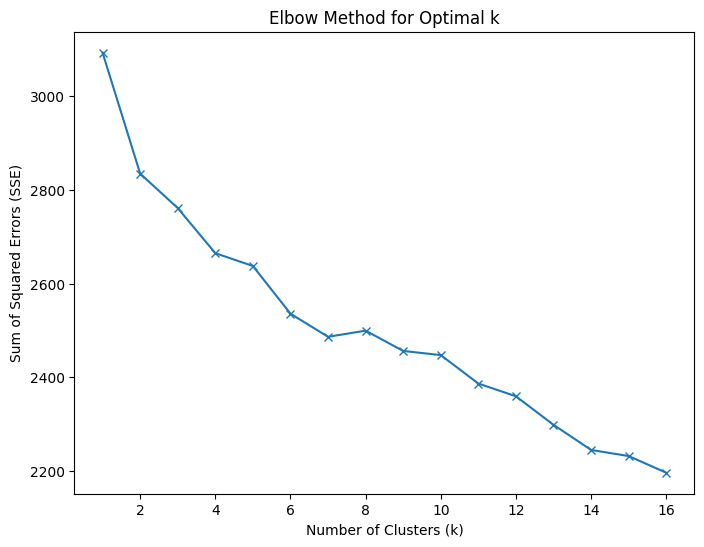

2
Kmeans
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
[0 1]


c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


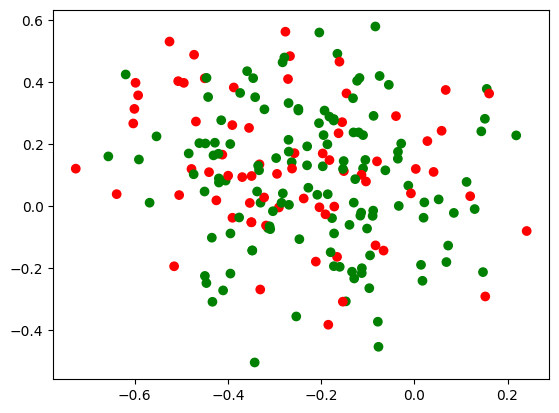

c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\site-packages\sklearn\cluster\_kmeans.py:14

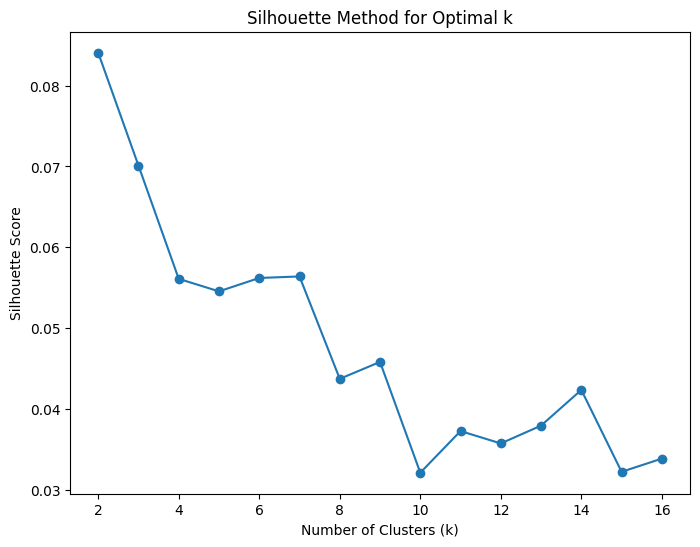

2
Kmeans
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
[0 1]


c:\Users\Veera\anaconda3\envs\torch-cuda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


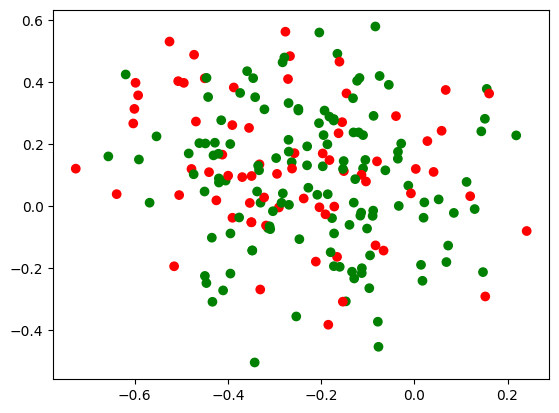

DBSCAN 0.0
KMEANS 0.457286432160804


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os
from PIL import Image
import pytesseract
from sklearn.datasets import fetch_20newsgroups

import re
import nltk
from nltk.corpus import stopwords

import time
from sentence_transformers import SentenceTransformer

# Set the Tesseract-OCR executable path if it's not in your PATH
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Folder containing images
image_folder = "screenshots/screenshots"

# List to store OCR results
ocr_texts = []

# Iterate over all images in the folder
for filename in os.listdir(image_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(image_folder, filename)
        img = Image.open(img_path)
        ocr_text = pytesseract.image_to_string(img)
        ocr_texts.append(ocr_text)

# Create a DataFrame from the OCR texts
df_ocr = pd.DataFrame({'text': ocr_texts})

# Debugging: Check if OCR text extraction worked
if df_ocr.empty:
    print("No text extracted from images.")
else:
    print(f"Extracted {len(df_ocr)} texts from images.")

# Preprocessing function
def preprocess_text(text: str) -> str:
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    
    # remove stopwords
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
    text = " ".join(tokens)
    text = text.lower().strip()
    
    return text

# Preprocess OCR text
df_ocr['text_cleaned'] = df_ocr['text'].apply(lambda text: preprocess_text(text))

# Debugging: Check if text_cleaned column has non-empty rows
df_ocr = df_ocr[df_ocr['text_cleaned'] != '']

if df_ocr.empty:
    print("All cleaned texts are empty after preprocessing. Exiting.")
else:
    print(f"Number of texts after preprocessing: {len(df_ocr)}")

# Load pre-trained Sentence Transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Encode the cleaned text
df_ocr['encode_transforemers'] = df_ocr['text_cleaned'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())

# Stack the encoded texts if available
if not df_ocr['encode_transforemers'].empty:
    X_transformers = np.vstack(df_ocr['encode_transforemers'])
else:
    print("No valid embeddings found. Exiting.")
    X_transformers = np.array([])

if X_transformers.size == 0:
    print("No data to cluster. Exiting.")
else:
    # DBSCAN Clustering
    from sklearn.cluster import DBSCAN 

    db_default = DBSCAN().fit(X_transformers) 
    db_labels = db_default.labels_

    print("DBSCAN")
    print(np.unique(db_default.labels_))
    print(db_default.labels_)

    # Visualization of DBSCAN clustering
    cl = {-1: 'k', 0 : 'r', 1 : 'g', 2 : 'b', 3 : 'c', 4 : 'm', 5 : 'y'}
    cvec = [cl[label] for label in db_labels]
    plt.scatter(X_transformers[:,0], X_transformers[:,1], c = cvec) 
    plt.show()

    # K-Means Clustering and Elbow Method for Optimal k
    from sklearn.cluster import KMeans

    sse = [] 
    k_range = range(1,17)
    for k in k_range:
        kmeans = KMeans(n_clusters=k,random_state=0,n_init="auto").fit(X_transformers)
        sse.append(kmeans.inertia_)

    plt.figure(figsize=(8,6))
    plt.plot(k_range,sse,marker='x')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('Elbow Method for Optimal k')
    plt.show()

    # Determine optimal k using second derivative
    sse_diff = np.diff(sse)
    sse_diff2 = np.diff(sse_diff)
    optimal_k = np.argmin(sse_diff) + 2
    print(optimal_k)

    # K-Means with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init="auto").fit(X_transformers)
    kmeans_labels = kmeans.labels_

    print("Kmeans")
    print(kmeans.labels_)
    print(np.unique(kmeans.labels_))

    # Visualization of K-Means clustering
    cvec = [cl[label] for label in kmeans_labels]
    plt.scatter(X_transformers[:,0], X_transformers[:,1], c = cvec) 
    plt.show()

    # Silhouette Method for Optimal k
    from sklearn.metrics import silhouette_score
    silhouette_scores= [] 
    k_range = range(2,17)
    for k in k_range:
        kmeans = KMeans(n_clusters=k,random_state=0,n_init="auto").fit(X_transformers)
        labels = kmeans.labels_
        score = silhouette_score(X_transformers, labels)
        silhouette_scores.append(score)

    plt.figure(figsize=(8, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method for Optimal k')
    plt.show()
    optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
    print(optimal_k_silhouette)

    # K-Means with optimal k from Silhouette Score
    kmeans = KMeans(n_clusters=optimal_k_silhouette, random_state=0, n_init="auto").fit(X_transformers)
    kmeans_labels = kmeans.labels_

    print("Kmeans")
    print(kmeans.labels_)
    print(np.unique(kmeans.labels_))

    # Visualization of Silhouette clustering
    silhouette = [cl[label] for label in kmeans_labels]
    plt.scatter(X_transformers[:,0], X_transformers[:,1], c = silhouette) 
    plt.show()

    # Compare clustering methods using Rand Index
    from sklearn import metrics
    print("DBSCAN", metrics.rand_score(df_ocr.index, db_labels))
    print("KMEANS", metrics.rand_score(df_ocr.index, kmeans_labels))
